### dev clustering with questionnaires

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [4]:
from compare_control import *
from clean_questions import *
from predict_digestive import *

#### dev prune

In [5]:
questionnaire = 'all'
idp = None
question_visits = [2]

In [6]:
df = load_patient_grouped(questionnaire=questionnaire, idp=idp, question_visits=question_visits, 
                          imputed=None, patient_grouping='simplified')

In [7]:
df1 = load_patient_grouped(questionnaire=questionnaire, idp=idp, question_visits=question_visits, 
                          imputed=True, patient_grouping='simplified')

Questionnaires from visits [2] shape=(4342, 95)
After imputation shape=(4342, 89)
Drop all nan cols shape=(4342, 89)


In [8]:
df.shape

(4342, 95)

In [213]:
def display_missing(df, thresh=0):
    c = 0
    for col in df.columns.tolist():         
        if df[col].isnull().sum()>0 and thresh==0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
            print(df[col].value_counts())
            c += 1
        elif df[col].isnull().sum()<thresh:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))

    print('\n')
    print(f'total number of missing cols={c}')

In [261]:
def impute_qs(df, nan_percent=0.9, freq_fill='median', 
              transform=True, transform_fn='sqrt'):
    """impute questionnaire df"""
    df_copy = df.copy()
    # replace prefer not to say and remove object
    df_copy = replace_noans(df_copy)
    # replace multiple choice fields
    df_copy = replace_multifield(df_copy)
    # replace specific fields
    df_copy = replace_specific(df_copy)
    # fill freq nan with median
    df_copy = replace_freq(df_copy, use=freq_fill)
    print(df_copy.shape)
    # transform freq cols
    if transform:
        df_copy = apply_transform(df_copy, use=transform_fn)
    # drop columns with threshold percentage nan
#     df_copy.dropna(axis=1, thresh=int(nan_percent*df_copy.shape[0]), inplace=True)
    return df_copy

def replace_noans(df):
    """replace prefer not to say if avaialable and remove object cols"""
    df_copy = df.copy()
    for col in df_copy.columns:
        if col!='label': # exclude label
            # remove time stamp cols
            if df_copy[col].dtype==object:
                df_copy.drop(col, axis=1, inplace=True)
            # replace nan with -818 (prefer not to say)
            elif np.any(df_copy[col]==-818):
                df_copy[col].replace({np.nan: -818.}, inplace=True)
    return df_copy

def replace_multifield(df):
    """replace multiple choice fields"""
    df_copy = df.copy()
    categories_multi = [
        '6160',#Leisure/social activities
        '6145',#Illness, injury, bereavement, stress in last 2 years
    ]
    for cat in categories_multi:
        p_cols = [col for col in df_copy.columns if col[:len(cat)+1]==str(cat)+'-']
        for c in p_cols: # replace with none of the above -7
            df_copy[c].replace(np.nan, -7., inplace=True)
    return df_copy

def replace_specific(df):
    """replace specific categories"""
    df_copy = df.copy()
    categories_zero = [
        '20123',#Single episode of probable major depression
        '20124',#Probable recurrent major depression (moderate)
        '20125', #Probable recurrent major depression (severe)
        '20481', #Self-harmed in past year
        '20484', #Attempted suicide in past year
        '20122', #Bipolar disorder status
        '20126', #Bipolar and major depression status
                 ]
    categories_nts = [
        '20414', #Frequency of drinking alcohol
    ]
    categories_to = [
        '20246', #Trail making completion status
        '20245', #Pairs matching completion status
        '20244', #Symbol digit completion status
    ]
    for c in df_copy.columns:
        for cat in categories_zero:
            if cat in c: 
                df_copy[c].replace(np.nan, 0., inplace=True)
        for cat in categories_nts:
            if cat in c:
                df_copy[c].replace(np.nan, -818., inplace=True) # treat as prefer not to say
        for cat in categories_to:
            if cat in c:
                df_copy[c].replace(np.nan, 1., inplace=True) # treat as abandoned
    return df_copy


def replace_freq(df, use='median'):
    """replace nan in freq with median"""
    df_copy = df.copy()
    for c in df_copy.columns:
        tmp = df_copy[c].value_counts()
        if tmp.shape[0]>7 and c!='label': # most likely frequency/idp
            if use == 'median':
                df_copy[c].fillna(df_copy[c].median(), inplace=True)
            elif use == 'mean':
                df_copy[c].fillna(df_copy[c].mean(), inplace=True)
        elif tmp.shape[0]<=7 and c!='label': # other types of freq
            if np.any(df_copy[c]==-3.) or np.any(df_copy[c]==-1.): # prefer not to say
                df_copy[c].replace({np.nan: -3.}, inplace=True)
#             elif np.any(df_copy[c]==-600.): # degree of bother, also has prefer not to say
#                 df_copy[c].replace({np.nan: -818.}, inplace=True)
    return df_copy

def apply_transform(df, use='sqrt'):
    """adding additional freq cols with transforms"""
    df_copy = df.copy()
    trans_freq = [
        '22040', # Summed MET minutes per week for all activity
        '20156', # Duration to complete numeric path (trail #1)
        '20157', # Duration to complete alphanumeric path (trail #2)
    ]
    if use=='log':
        fn = np.log
    elif use=='sqrt':
        fn = np.sqrt
    for c in df_copy.columns:
        for cat in trans_freq:
            if cat in c:
                df_copy[c+'-1'] = df_copy[c].apply(fn)
    return df_copy

In [262]:
df.shape

(4342, 95)

In [263]:
dfc = impute_qs(df)

(4342, 89)


In [264]:
dfc.shape

(4342, 92)

<AxesSubplot:ylabel='Frequency'>

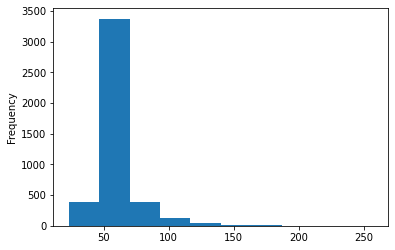

In [265]:
dfc['20157-0.0'].plot(kind='hist')#.apply(np.sqrt)

<AxesSubplot:ylabel='Frequency'>

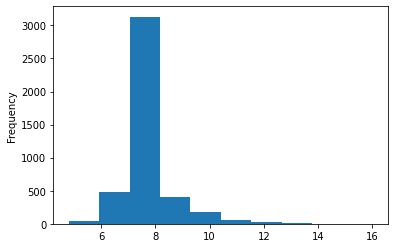

In [267]:
dfc['20157-0.0-1'].plot(kind='hist')

In [233]:
display_missing(df_copy, thresh=0)



total number of missing cols=0


In [36]:
def replace_noans(df):
    """replace prefer not to say if avaialable and remove object cols"""
    df_copy = df.copy()
    for col in df_copy.columns:
        if col!='label': # exclude label
            # remove time stamp cols
            if df_copy[col].dtype==object:
                df_copy.drop(col, axis=1, inplace=True)
            # replace nan with -818 (prefer not to say)
            elif np.any(df_copy[col]==-818):
                df_copy[col].replace({np.nan: -818.}, inplace=True)
    return df_copy

In [13]:
df['6160-2.0'].value_counts()

 1.0    1568
-7.0    1043
 2.0     619
 5.0     569
 3.0     388
 4.0     131
-3.0       3
Name: 6160-2.0, dtype: int64

In [22]:
df['6160-2.1'].value_counts()

5.0    631
2.0    370
3.0    290
4.0    154
Name: 6160-2.1, dtype: int64

In [29]:
df1['6160-2.1'].value_counts()

0.0    2897
5.0     631
2.0     370
3.0     290
4.0     154
Name: 6160-2.1, dtype: int64

In [21]:
np.median(np.array(df['6160-2.0'].value_counts().index))

2.0

In [12]:
df1['6160-2.0'].value_counts()

 1.0    1568
-7.0    1043
 2.0     619
 5.0     569
 3.0     388
 4.0     131
-3.0      24
Name: 6160-2.0, dtype: int64

In [28]:
display_missing(df, thresh=30)

21003-2.0 column missing values: 0
6145-2.0 column missing values: 21
1031-2.0 column missing values: 21
1160-2.0 column missing values: 21
4581-2.0 column missing values: 21
1200-2.0 column missing values: 21
4537-2.0 column missing values: 21
2100-2.0 column missing values: 21
4548-2.0 column missing values: 21
1170-2.0 column missing values: 21
4559-2.0 column missing values: 21
2090-2.0 column missing values: 21
20116-2.0 column missing values: 21
53-2.0 column missing values: 0
4526-2.0 column missing values: 21
2080-2.0 column missing values: 21
6160-2.0 column missing values: 21
4570-2.0 column missing values: 21
eid column missing values: 0
label column missing values: 0


total number of missing cols=0


<AxesSubplot:ylabel='Frequency'>

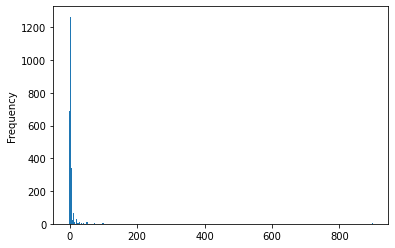

In [38]:
df['4620-2.0'].plot(kind='hist')

In [33]:
print(df['5386-2.0'].value_counts())
df['5386-2.0'].value_counts().median()

KeyError: '5386-2.0'

In [27]:
df['5386-2.0'].value_counts().values

array([438, 342, 276, 167,  92,  64,  59,  39,  21,  20,  15,  15,  11,
         9,   6,   6,   5,   5,   4,   4,   4,   3,   3,   2,   2,   2,
         2,   1,   1,   1,   1,   1,   1,   1])

<AxesSubplot:ylabel='Frequency'>

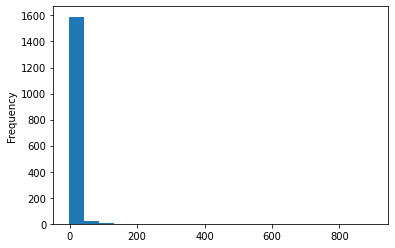

In [15]:
# df['5386-2.0'].value_counts()
df['5386-2.0'].plot(kind='hist',bins=20)

<AxesSubplot:ylabel='Frequency'>

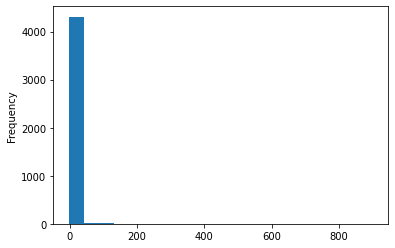

In [16]:
# df['5386-2.0'].value_counts()
df1['5386-2.0'].plot(kind='hist',bins=20)

In [8]:
display_missing(df)

6145-2.1 column missing values: 3900
4620-2.0 column missing values: 1848
20526-0.0 column missing values: 1292
20499-0.0 column missing values: 1292
20486-0.0 column missing values: 3744
4559-2.0 column missing values: 21
20127-0.0 column missing values: 763
20529-0.0 column missing values: 1292
4570-2.0 column missing values: 21
20434-0.0 column missing values: 2341
20458-0.0 column missing values: 1292
4537-2.0 column missing values: 21
20528-0.0 column missing values: 1292
20479-0.0 column missing values: 1292
20433-0.0 column missing values: 2341
20480-0.0 column missing values: 1292
20123-0.0 column missing values: 4229
20530-0.0 column missing values: 1292
20489-0.0 column missing values: 1292
20531-0.0 column missing values: 1292
20400-0.0 column missing values: 1291
20500-0.0 column missing values: 1292
20523-0.0 column missing values: 1292
6145-2.2 column missing values: 4256
20491-0.0 column missing values: 1292
20494-0.0 column missing values: 2845
20498-0.0 column missing 

#### dev tuning

In [5]:
questionnaire = None #'all'
idp = 'all'#['t1vols','taskfmri']#'all'
question_visits = [2]
impute_flag = True
datasets = [
            load_patient_grouped(questionnaire=questionnaire, idp=idp, question_visits=question_visits, imputed=impute_flag, patient_grouping='simplified'), # pain type
            load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, question_visits=question_visits, imputed=impute_flag), # digestive
            load_patient_matched(questionnaire=questionnaire, idp=idp, question_visits=question_visits, imputed=impute_flag) # patient control
            ]
dataset_names = ['paintype', 'digestive', 'paincontrol']

Questionnaires from visits [2] shape=(4342, 869)
After imputation shape=(4342, 869)
Drop all nan cols shape=(4342, 869)
(3951, 3797)
Questionnaires from visits [2] shape=(3951, 869)
After imputation shape=(3951, 869)
Drop all nan cols shape=(3951, 869)
Patients=4342, controls=4376
Questionnaires from visits [2] shape=(8718, 869)
After imputation shape=(8718, 869)
Drop all nan cols shape=(8718, 869)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


ds = datasets[0]
y = ds['label']
if y.dtype==object:
    y = pd.get_dummies(y).iloc[:,0]
X = ds.drop(['label','eid'], axis=1)
X = StandardScaler().fit_transform(X)

In [7]:
X.shape

(4342, 867)

In [20]:
import optuna
import functools
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


def opt(X_train, y_train, X_eval, y_eval, trial):
    # param_list
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.2, 0.01)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1)

    xgboost_tuna = xgb.XGBClassifier(
        random_state=42,
        tree_method='auto',
        eval_metric = 'auc',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight=scale_pos_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test_prob = xgboost_tuna.predict_proba(X_eval)[:,1]

    return ((roc_auc_score(y_eval, tuna_pred_test_prob)))

In [64]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.25, random_state=27)

In [50]:
# define undersampling strategy
under = RandomUnderSampler()
# fit and apply the transform
X, y = under.fit_resample(X, y)

In [65]:
#balance dataset
over = RandomOverSampler()
# fit and apply the transform
X, y = over.fit_resample(X, y)

In [46]:
study = optuna.create_study()
study.optimize(functools.partial(opt, X_train, y_train, X_eval, y_eval), n_trials=3)

[I 2021-04-19 12:23:58,990] A new study created in memory with name: no-name-7a109390-1fc1-4dfa-81f8-f808a7cfd4c7
[I 2021-04-19 12:24:02,441] Trial 0 finished with value: 0.6199504426049952 and parameters: {'n_estimators': 184, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.17, 'scale_pos_weight': 64, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.6199504426049952.
[I 2021-04-19 12:25:00,717] Trial 1 finished with value: 0.6232345178029555 and parameters: {'n_estimators': 447, 'max_depth': 10, 'min_child_weight': 20, 'learning_rate': 0.060000000000000005, 'scale_pos_weight': 14, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.6199504426049952.
[I 2021-04-19 12:25:58,866] Trial 2 finished with value: 0.6026322877201802 and parameters: {'n_estimators': 656, 'max_depth': 18, 'min_child_weight': 15, 'learning_rate': 0.16, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial 2 with value: 0.6026322

In [47]:
study.best_params

{'n_estimators': 656,
 'max_depth': 18,
 'min_child_weight': 15,
 'learning_rate': 0.16,
 'scale_pos_weight': 28,
 'subsample': 0.7,
 'colsample_bytree': 0.7}

In [48]:
clf = xgb.XGBClassifier(**study.best_params)

In [66]:
from sklearn.model_selection import cross_validate

cv_fold = 3
cv_results = cross_validate(clf, X, y, cv=cv_fold, return_train_score=False, scoring=('accuracy', 'f1', 'roc_auc'))
df_res = pd.DataFrame(cv_results)
df_res['classifier'] = str(clf)
# df_res['dataset'] = dataset_names[ds_cnt]
score = df_res['test_accuracy'].mean()
# print res
print(f"{cv_fold}-fold CV classification with classifier {clf}:\n"
    f"test ROC AUC={df_res['test_roc_auc'].mean():.4f}, test accuracy={df_res['test_accuracy'].mean():.4f}, test f1={df_res['test_f1'].mean():.4f}")

[12:41:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:43:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3-fold CV classification with classifier XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.7, gamma=None,
              gpu_id=None, importance_type='gain', interaction_

In [67]:
df_res # over sampling

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,classifier
0,55.947556,0.038698,0.713231,0.760777,0.755593,"XGBClassifier(base_score=None, booster=None, c..."
1,57.742243,0.033444,0.701306,0.754435,0.769794,"XGBClassifier(base_score=None, booster=None, c..."
2,62.912708,0.034797,0.885795,0.871729,0.983698,"XGBClassifier(base_score=None, booster=None, c..."


In [52]:
df_res # under sampling

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,classifier
0,44.877571,0.029773,0.540564,0.630234,0.572951,"XGBClassifier(base_score=None, booster=None, c..."
1,45.723843,0.030597,0.542328,0.633733,0.599064,"XGBClassifier(base_score=None, booster=None, c..."
2,45.986714,0.029729,0.565256,0.650602,0.610509,"XGBClassifier(base_score=None, booster=None, c..."


In [29]:
df_res # without under sampling

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,classifier
0,87.758425,0.034072,0.619475,0.750113,0.590098,"XGBClassifier(base_score=None, booster=None, c..."
1,90.357425,0.034135,0.610919,0.746966,0.604875,"XGBClassifier(base_score=None, booster=None, c..."
2,88.426926,0.038427,0.597097,0.730716,0.566783,"XGBClassifier(base_score=None, booster=None, c..."


In [ ]:

# clf = xgb.XGBClassifier(**study.best_params)
clf = xgb.XGBClassifier()


# over = RandomOverSampler(sampling_strategy=0.5)
# # fit and apply the transform
# X, y = over.fit_resample(X, y)
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy=0.5)
# # fit and apply the transform
# X, y = under.fit_resample(X, y)

clf.fit(X,y)

#### dev cv

In [48]:
df0_pt = load_patient_grouped(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=None, 
                          patient_grouping='simplified')
print(df0_pt.shape)
df1_pt = load_patient_grouped(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=False, 
                          patient_grouping='simplified')
print(df1_pt.shape)
print(df1_pt.shape[0]/df0_pt.shape[0])

y = pd.get_dummies(df1_pt['label']).iloc[:,0]
print(y.sum()/df1_pt.shape[0])

(4342, 869)
(3412, 869)
0.7858129894058038
0.6016998827667057


In [49]:
df0_dg = load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, 
                         question_visits=question_visits, imputed=None)
print(df0_dg.shape)
df1_dg = load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, 
                         question_visits=question_visits, imputed=False)
print(df1_dg.shape)
print(df1_dg.shape[0]/df0_dg.shape[0])
print(df1_dg['label'].sum()/df1_dg.shape[0])

(3951, 3797)
(3951, 869)
(3951, 3797)
(3187, 869)
0.8066312325993419
0.318167555695011


In [50]:
df0_pc = load_patient_matched(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=None)
print(df0_pc.shape)# patient control
df1_pc = load_patient_matched(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=False)
print(df1_pc.shape)
print(df1_pc.shape[0]/df0_pc.shape[0])
print(df1_pc['label'].sum()/df1_pc.shape[0])

Patients=4342, controls=4376
(8718, 869)
Patients=4342, controls=4376
(6841, 869)
0.7846983253039688
0.4987574915947961


In [43]:
def check_categorical(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    return categorical_columns

In [44]:
cat_cols = check_categorical(df1)
print(cat_cols)

[]


In [45]:
def display_missing(df):
    c = 0
    for col in df.columns.tolist():         
        if df[col].isnull().sum()>0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
            c += 1
    print('\n')
    print(f'total number of missing cols={c}')

In [46]:
display_missing(df1)



total number of missing cols=0


In [51]:
# umap test

In [54]:
import umap

In [94]:
dff_imputed = df1_dg

In [95]:
y_label = dff_imputed['label']
y = pd.get_dummies(y_label).iloc[:,0]
X = dff_imputed.drop(['label','eid'], axis=1)

In [96]:
y.value_counts()/y.shape[0]

1    0.681832
0    0.318168
Name: 0, dtype: float64

In [76]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [97]:
reducer = umap.UMAP()

In [98]:
embedding = reducer.fit_transform(X)
embedding.shape

(3187, 2)

In [83]:
embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=4,
    random_state=42,
).fit_transform(X)

Text(0.5, 1.0, 'UMAP projection of dataset')

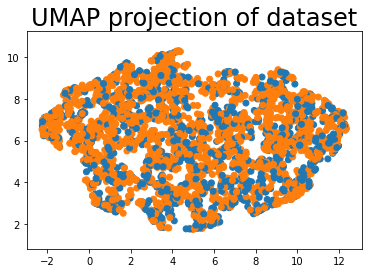

In [99]:
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in y.map({0:0, 1:1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of dataset', fontsize=24)

#### dev questions

In [85]:
questionnaire = 'all'
idp = None

In [87]:
df0_pt = load_patient_grouped(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=None, 
                          patient_grouping='simplified')
print(df0_pt.shape)
df1_pt = load_patient_grouped(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=True, 
                          patient_grouping='simplified')
print(df1_pt.shape)
print(df1_pt.shape[0]/df0_pt.shape[0])

y = pd.get_dummies(df1_pt['label']).iloc[:,0]
print(y.sum()/df1_pt.shape[0])

(4342, 95)
Questionnaires from visits [2] shape=(4342, 95)
After imputation shape=(4342, 89)
Drop all nan cols shape=(4342, 89)
(4342, 89)
1.0
0.6082450483648089


30.0    64
35.0    48
40.0    44
28.0    36
25.0    31
22.0    31
21.0    30
50.0    28
33.0    27
27.0    27
24.0    26
20.0    26
29.0    25
45.0    24
23.0    24
32.0    23
38.0    22
31.0    21
26.0    21
48.0    17
43.0    16
51.0    14
54.0    14
42.0    13
34.0    13
36.0    12
44.0    12
39.0    12
19.0    12
60.0    11
49.0    11
37.0    10
52.0    10
18.0     9
55.0     9
47.0     8
56.0     8
41.0     7
58.0     7
46.0     7
53.0     7
57.0     7
59.0     5
61.0     5
17.0     5
64.0     4
65.0     4
62.0     2
63.0     2
9.0      1
16.0     1
75.0     1
14.0     1
12.0     1
Name: 22507-0.0, dtype: int64

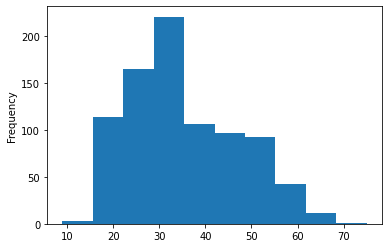

In [91]:
df0_pt['22507-0.0'].plot(kind='hist')
df0_pt['22507-0.0'].value_counts()

33.0    3513
30.0      64
35.0      48
40.0      44
28.0      36
25.0      31
22.0      31
21.0      30
50.0      28
27.0      27
24.0      26
20.0      26
29.0      25
45.0      24
23.0      24
32.0      23
38.0      22
31.0      21
26.0      21
48.0      17
43.0      16
51.0      14
54.0      14
42.0      13
34.0      13
36.0      12
44.0      12
39.0      12
19.0      12
60.0      11
49.0      11
37.0      10
52.0      10
18.0       9
55.0       9
47.0       8
56.0       8
41.0       7
58.0       7
46.0       7
53.0       7
57.0       7
59.0       5
61.0       5
17.0       5
64.0       4
65.0       4
62.0       2
63.0       2
9.0        1
16.0       1
75.0       1
14.0       1
12.0       1
Name: 22507-0.0, dtype: int64

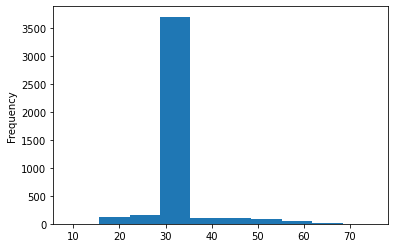

In [92]:
df1_pt['22507-0.0'].plot(kind='hist')
df1_pt['22507-0.0'].value_counts()

In [88]:
display_missing(df0_pt)

4537-2.0 column missing values: 21
1160-2.0 column missing values: 21
20122-0.0 column missing values: 4330
1200-2.0 column missing values: 21
20527-0.0 column missing values: 1292
20125-0.0 column missing values: 4245
20484-0.0 column missing values: 4254
20137-0.0 column missing values: 2127
22507-0.0 column missing values: 3486
20496-0.0 column missing values: 2845
20487-0.0 column missing values: 1292
20495-0.0 column missing values: 1292
20488-0.0 column missing values: 1292
20494-0.0 column missing values: 2845
6145-2.0 column missing values: 21
22506-0.0 column missing values: 1943
6145-2.1 column missing values: 3900
20157-0.0 column missing values: 2421
6160-2.4 column missing values: 4341
4620-2.0 column missing values: 1848
20116-2.0 column missing values: 21
20245-0.0 column missing values: 2127
20499-0.0 column missing values: 1292
20521-0.0 column missing values: 1292
20123-0.0 column missing values: 4229
20127-0.0 column missing values: 763
20498-0.0 column missing value

In [49]:
df0_dg = load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, 
                         question_visits=question_visits, imputed=None)
print(df0_dg.shape)
df1_dg = load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, 
                         question_visits=question_visits, imputed=False)
print(df1_dg.shape)
print(df1_dg.shape[0]/df0_dg.shape[0])
print(df1_dg['label'].sum()/df1_dg.shape[0])

(3951, 3797)
(3951, 869)
(3951, 3797)
(3187, 869)
0.8066312325993419
0.318167555695011


In [50]:
df0_pc = load_patient_matched(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=None)
print(df0_pc.shape)# patient control
df1_pc = load_patient_matched(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=False)
print(df1_pc.shape)
print(df1_pc.shape[0]/df0_pc.shape[0])
print(df1_pc['label'].sum()/df1_pc.shape[0])

Patients=4342, controls=4376
(8718, 869)
Patients=4342, controls=4376
(6841, 869)
0.7846983253039688
0.4987574915947961


#### previous dev

In [20]:
df_subjects['21003-2.0'].isna().sum()

0

In [10]:
# main questionnaire file
qs_path = os.path.join('..', 'funpack_cfg', 'questions_subjs_disease_visit2_extended.tsv')
# load subjects
df_subjects = pd.read_csv(qs_path, sep='\t')
# create disease label
df_disease_label = disease_label(df_subjects, visits=[2])
# load questionnaire codes
# questionnaire_ls = ['lifestyle','mental','cognitive']
questionnaire_ls = ['all']
for q in questionnaire_ls:
    print(q)
    df_qs = load_qscode(q)
    # extract questionnaire of interest
    df_qs = extract_qs(df_subjects, df_questionnaire=df_qs, visits=[0,2])
    # exclude multi diseases subjects
    df_exclude, df_label_exclude = exclude_multidisease(df_qs, df_disease_label)

/home/fs0/syzhang/.conda/envs/biobank/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2445,2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2739,2740,2741,2742,2743,2744,2745,2746,2747,2750,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,28

all


In [27]:
df_exclude.columns.duplicated().sum()

0

In [29]:
df_exclude.shape

(4193, 740)

In [30]:
df_label_exclude.shape

(4193, 5)

In [31]:
# reverse one hot encoding
label_exclude = df_label_exclude.idxmax(axis=1)
dff = df_exclude.merge(label_exclude.rename('label'), left_index=True, right_index=True)

In [32]:
dff.shape

(4193, 741)

In [41]:
print(dff.shape)
dff_imputed = impute_qs(dff, freq_fill='median', nan_percent=0.9)
print(dff_imputed.shape)
dff_imputed = dff_imputed.dropna(how='all', axis=1)
print(dff_imputed.shape)

(4193, 741)
(4193, 336)
(4193, 336)


In [42]:
dff_imputed.columns[dff_imputed.isna().sum()>0]

Index([], dtype='object')

#### check individual questionnaire

In [11]:
def extract_qs(df_subjects, df_questionnaire, visits=[2]):
    """extract questionnaire set out of 5 possible"""
    # load questionnaire code of interest
    field_code = df_questionnaire['code'].to_list()
    # extract all fields with questionnaire code
    field_cols = []
    for code in field_code:
#         print(code)
#         print(field_cols)
        cols_ls = [col for col in df_subjects.columns if str(code)+'-' in col]
        if visits != None: # limit to visits only
            if len(cols_ls) > 1:
                cols_exclude = []
                for visit in visits:
                    for col in cols_ls:
                        if '-'+str(visit) in col:
                            cols_exclude.append(col)
                cols_ls = cols_exclude
        else:
            cols_ls = cols_ls
        field_cols += cols_ls
    # append eid
    field_cols += ['eid']
    # remove duplicate
    field_cols_rm = list(set(field_cols))
    df_qs = df_subjects[field_cols_rm]
    # remove duplicated columns
    df_qs_rm = df_qs.loc[:, ~df_qs.columns.duplicated()]
    return df_qs_rm

In [12]:
# questionnaire_ls = ['lifestyle','mental','cognitive','digestive','all']
questionnaire_ls = ['all']

for q in questionnaire_ls:
    df_qs = load_qscode(q)
    # extract questionnaire of interest
    df_qs = extract_qs(df_exclude, df_questionnaire=df_qs)
    print(q)
    print(df_qs.shape)

all
(4193, 103)


In [13]:
df_qs.shape

(4193, 103)

In [14]:
cnt = 0
for c in df_qs.columns:
    counts = df_qs[c].value_counts()
    if len(counts) > 100:
        cnt += 1
print(cnt/df_qs.shape[0])

0.0026234199856904365


In [15]:
df_label_exclude.head()

,irritable bowel syndrome,migraine,back pain,osteoarthritis,fibromyalgia
eid,,,,,
1002910,1,0,0,0,0
1010078,1,0,0,0,0
1013470,1,0,0,0,0
1018785,1,0,0,0,0
1024557,1,0,0,0,0


In [16]:
# reverse one hot encoding
label_exclude = df_label_exclude.idxmax(axis=1)

In [17]:
dff = df_qs.merge(label_exclude.rename('label'), left_index=True, right_index=True)

#### check nan

In [18]:
df_nan = pd.isna(dff).sum()/dff.shape[0]

In [19]:
def impute_qs(df, nan_percent=0.9, freq_fill='median'):
    """impute questionnaire df"""
    df_copy = df.copy()
    for col in df_copy.columns:
        if col!='label': # exclude label
            # remove time stamp cols
            if df_copy[col].dtype==object:
                df_copy.drop(col, axis=1, inplace=True)
            # replace nan with -818 (prefer not to say)
            elif np.any(df_copy[col]<-810):
#                 print(col)
                df_copy[col].replace({np.nan: -818.}, inplace=True)
    # fill freq nan with median
    df_copy = replace_freq(df_copy, use=freq_fill)
    # replace specific fields
    df_copy = replace_specific(df_copy)
    # drop columns with threshold percentage nan
    df_copy.dropna(axis=1, thresh=int(nan_percent*df_copy.shape[0]), inplace=True)
    return df_copy

def replace_freq(df, use='median'):
    """replace nan in freq with median"""
    df_copy = df.copy()
    for c in df_copy.columns:
        tmp = df_copy[c].value_counts()
        if tmp.shape[0]>7 and c!='label': # most likely frequency
            if use == 'median':
                df_copy[c].fillna(tmp.median(), inplace=True)
            elif use == 'mean':
                df_copy[c].fillna(tmp.mean(), inplace=True)
        elif tmp.shape[0]<=7 and c!='label': # other types of freq
            if np.any(df_copy[c]==-3.) or np.any(df_copy[c]==-1.): # prefer not to say
                df_copy[c].replace({np.nan: -3.}, inplace=True)
            elif np.any(df_copy[c]==-600.): # degree of bother, also has prefer not to say
                df_copy[c].replace({np.nan: -818.}, inplace=True)

    return df_copy

def replace_specific(df):
    """replace specific categories"""
    df_copy = df.copy()
    categories_zero = [
        '6160',#Leisure/social activities
        '6145',#Illness, injury, bereavement, stress in last 2 years
        '20123',#Single episode of probable major depression
        '20124',#Probable recurrent major depression (moderate)
        '20125', #Probable recurrent major depression (severe)
        '20481', #Self-harmed in past year
        '20484', #Attempted suicide in past year
        '20122', #Bipolar disorder status
        '20126', #Bipolar and major depression status
                 ]
    categories_nts = [
        '20414', #Frequency of drinking alcohol
    ]
    categories_to = [
        '20246', #Trail making completion status
        '20245', #Pairs matching completion status
        '20244', #Symbol digit completion status
    ]
    for c in df_copy.columns:
        for cat in categories_zero:
            if cat in c: 
                df_copy[c].replace(np.nan, 0., inplace=True)
        for cat in categories_nts:
            if cat in c:
                df_copy[c].replace(np.nan, -818., inplace=True) # treat as prefer not to say
        for cat in categories_to:
            if cat in c:
                df_copy[c].replace(np.nan, 1., inplace=True) # treat as abandoned
    return df_copy

In [20]:
print(dff.shape)
dff_imputed = impute_qs(dff, freq_fill='median', nan_percent=0.)
print(dff_imputed.shape)
dff_imputed = dff_imputed.dropna(how='all', axis=1)
print(dff_imputed.shape)

(4193, 104)
(4193, 98)
(4193, 98)


#### check other nan (with no prefer not to say)

In [21]:
mas_na = dff_imputed.columns[dff_imputed.isna().sum()/dff_imputed.shape[0]>0.]

In [22]:
for c in mas_na:
# for c in dff_imputed.columns:
#     plt.subplots()
#     dff_imputed[c].plot(kind='hist')

    print(c)
    print(dff_imputed[c].value_counts())       
    print(dff_imputed[c].value_counts().sum())

In [23]:
dff_imputed_na['label'].value_counts()/dff_imputed_na.shape[0]

NameError: name 'dff_imputed_na' is not defined

#### multilabel classification

In [ ]:
dff_imputed_na = dff_imputed.dropna(axis=1)

In [ ]:
dff_imputed_na.shape

In [ ]:
df_test = dff_imputed_na

In [ ]:
df_test.shape

In [ ]:
# importing necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
  
y = df_test['label']
X = df_test.drop('label', axis=1)
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)

In [ ]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
predicted = clf.predict(X_test)
  
# creating a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(cm,display_labels=clf.classes_).plot()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"Classification report for classifier {dtree_model}:\n"
      f"{classification_report(y_test, predicted)}\n"
      f"ROC AUC={auc}")

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier().fit(X_train, y_train)
predicted = clf.predict(X_test)

# creating a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(cm).plot()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"Classification report for classifier {clf}:\n"
      f"{classification_report(y_test, predicted)}\n"
      f"ROC AUC={auc}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5).fit(X_train, y_train)
predicted = clf.predict(X_test)

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"Classification report for classifier {clf}:\n"
      f"{classification_report(y_test, predicted)}\n"
      f"ROC AUC={auc}")

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
predicted = clf.predict(X_test)
auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"Classification report for classifier {clf}:\n"
      f"{classification_report(y_test, predicted)}\n"
      f"ROC AUC={auc}")

In [ ]:
from sklearn import svm
clf = svm.SVC().fit(X_train, y_train)
predicted = clf.predict(X_test)
print(f"Classification report for classifier {clf}:\n"
      f"{classification_report(y_test, predicted)}\n")